# Installs and Imports

In [3]:
!pip install transformers
!pip install torch torchvision torchaudio
!pip install emot --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.3 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import emot

from sklearn.metrics import fbeta_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

from scipy.stats import binomtest

from tqdm import tqdm

# Load Data and Models

## Tweet Data

In [5]:
file_name = "exp_final.csv"
df = pd.read_csv(file_name)

In [ ]:
np.mean(df['sarcastic'])

0.9035326086956522

## Sentiment Classifier

In [7]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def classify_sentiment(text, two_dimensional=False) :
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    #scores = softmax(scores)

    if two_dimensional:
      pos_ratio = scores[2] / (scores[0] + scores[2])
      neg_ratio = 1 - pos_ratio
      scores[0] = scores[0] + scores[1]*neg_ratio
      scores[2] = scores[2] + scores[1]*pos_ratio
      scores = np.array([scores[0], scores[2]])

    # [ negative, neutral, positive ]
    return scores

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
classify_sentiment("I sarcasm")

array([-0.80626327,  0.49641022, -0.24217099], dtype=float32)

In [ ]:
classify_sentiment("I just love")

array([-1.8679188 , -0.57147187,  2.4821439 ], dtype=float32)

In [ ]:
np.linalg.norm(classify_sentiment("I sarcasm") - classify_sentiment("I just love"))

3.1127763

# Functions



In [8]:
emot_obj = emot.core.emot()

def extract_verb_np_exp13(tweet):
  tweet = tweet.strip()
  tweet_split = tweet.split()
  verb_idx = min([i for i,x in enumerate(tweet_split) if re.match(r"(?i)(.*lo+v)|ha+t", x) ])
  verb_char_idx = sum([len(word)+1 for word in tweet_split[:verb_idx]])

  emojis = emot_obj.emoji(tweet)
  emoticons = emot_obj.emoticons(tweet)

  emoji_idx_list = emojis.get('location') + emoticons.get('location')
  emoji_idx_list = sorted(emoji_idx_list, key= lambda x : x[1])

  while emoji_idx_list and verb_char_idx >= emoji_idx_list[0][0]:
    pop_emoji = emoji_idx_list.pop(0)

  if emoji_idx_list:
    emoji_idx = emoji_idx_list[0][0]
    noun_phrase = tweet[verb_char_idx + len(tweet_split[verb_idx]):emoji_idx].strip()
  else:
    noun_phrase = tweet[verb_char_idx + len(tweet_split[verb_idx]):].strip()

  try :
    i_idx = [x.lower() for x in tweet_split].index("i")
  except Exception :
    i_idx = min([i for i,x in enumerate(tweet_split) if x.lower().startswith("i'")])
  verb = " ".join(tweet_split[i_idx + 1:verb_idx + 1])

  noun_phrase_split = noun_phrase.split()
  idx = len(noun_phrase_split) - 1
  while noun_phrase_split[idx].startswith("@"):
    idx = idx - 1
  noun_phrase = " ".join(noun_phrase_split[:idx + 1])


  return verb, noun_phrase

In [9]:
def extract_verb_np_exp2(tweet) :
  tweet = tweet.strip()
  tweet_split = tweet.split()
  verb_idx = min([i for i,x in enumerate(tweet_split) if re.match(r"(?i)(.*lo+v)|ha+t", x) ])
  if 'Love love love' in tweet :
     verb_idx += 2
     verb = 'Love love love'
  else :
    beginning_verb_idx = verb_idx
    while beginning_verb_idx > 0 and not tweet_split[beginning_verb_idx - 1].startswith("@") :
      beginning_verb_idx -= 1
    verb = " ".join(tweet_split[beginning_verb_idx:verb_idx + 1])
    verb = verb.replace('😍', '')

  verb_char_idx = sum([len(word)+1 for word in tweet_split[:verb_idx]])

  emojis = emot_obj.emoji(tweet)
  emoticons = emot_obj.emoticons(tweet)

  emoji_idx_list = emojis.get('location') + emoticons.get('location')
  emoji_idx_list = sorted(emoji_idx_list, key= lambda x : x[1])

  while emoji_idx_list and verb_char_idx >= emoji_idx_list[0][0]:
    pop_emoji = emoji_idx_list.pop(0)


  if emoji_idx_list:
    emoji_idx = emoji_idx_list[0][0]
    noun_phrase = tweet[verb_char_idx + len(tweet_split[verb_idx]):emoji_idx].strip()
  else:
    noun_phrase = tweet[verb_char_idx + len(tweet_split[verb_idx]):].strip()


  noun_phrase_split = noun_phrase.split()
  idx = len(noun_phrase_split) - 1
  while noun_phrase_split[idx].startswith("@"):
    idx = idx - 1
  noun_phrase = " ".join(noun_phrase_split[:idx + 1])

  return verb, noun_phrase

In [10]:
def extract_verb_np(tweet, exp) :
  try :
    if exp == 'exp2' :
      return extract_verb_np_exp2(tweet)
    return extract_verb_np_exp13(tweet)
  except :
    print("error : ", tweet)
    raise

In [11]:
def sentiment_distance(tweet, exp, method="contextual"):
  """Calculates the sentiment distance (euclidic distance) between the sentiment scores of the V and NP of a given tweet."""
  verb, noun_phrase = extract_verb_np(tweet, exp)

  if method == "contextual":
    tweet_sentiment = classify_sentiment(tweet)
    tweet_no_v_sentiment = classify_sentiment(tweet.replace(verb, ""))
    tweet_no_np_sentiment = classify_sentiment(tweet.replace(noun_phrase, ""))
    v_sentiment = tweet_sentiment - tweet_no_v_sentiment
    np_sentiment = tweet_sentiment - tweet_no_np_sentiment

  if method == "non-contextual":
    v_sentiment = classify_sentiment("verb")
    np_sentiment = classify_sentiment(noun_phrase)

  return np.linalg.norm(v_sentiment - np_sentiment)
  # return np.linalg.norm(v_sentiment - np_sentiment) / np.sqrt(2)
  # return np.linalg.norm(softmax(v_sentiment - np_sentiment))

def is_sarc(sentiment_dist, threshold):
  """Returns True if the sentiment distance is greater than a given threshold and False otherwise."""

  return sentiment_dist > threshold

In [12]:
def get_sentiment_distance(tweets, gold_annotations, exps, method):
    tweet_annotation_sentiment_distance = []
    for tweet, annotation, exp in tqdm(zip(tweets, gold_annotations, exps), total=len(tweets)):
      tweet_annotation_sentiment_distance.append((tweet, annotation, sentiment_distance(tweet, exp, method)))

    max_sentiment = max([item[2] for item in tweet_annotation_sentiment_distance])
    tweet_annotation_sentiment_distance = [(t, a, sd/max_sentiment) for t, a, sd in tweet_annotation_sentiment_distance]

    return tweet_annotation_sentiment_distance

In [13]:
def define_threshold(tweet_annotation_sentiment_distance, threshold_list, metric, beta=0.3):
  """
  Creates a list of tuples containing 1) the tweet body, 2) the sarc/non-sarc gold annotation, 3) the sentiment distance between V and NP.
  Then, iterates over a list of thresholds and for each threshold calculates the accuracy between the gold annotations and the predicted values.
  Returns a dictionary of thresholds and accuracies for those thresholds.
  """

  threshold_accuracy_dict = {}
  for threshold in tqdm(threshold_list, total=len(threshold_list)):
    y_true = [item[1] for item in tweet_annotation_sentiment_distance]
    y_pred = [int(is_sarc(item[2], threshold)) for item in tweet_annotation_sentiment_distance]

    if metric == "f-score":
      score = fbeta_score(y_true, y_pred, beta=beta)

    if metric == "precision":
      score = precision_score(y_true, y_pred, zero_division=0)

    if metric == "youden_j":
      tpr, tpr, thresholds = roc_curve(y_true, y_pred)
      score = np.argmax(tpr - fpr)

    threshold_accuracy_dict[threshold] = score

  return threshold_accuracy_dict

#Exploring the Sentiment Distances in exp_final

This is just to get an idea of what we're working with.

In [14]:
tweet_annotation_sentiment_distance = get_sentiment_distance(df['modified_tweet'], df['sarcastic'], df['exp'], method="contextual")
df['sentiment_distance'] = [x[2] for x in tweet_annotation_sentiment_distance]

100%|██████████| 736/736 [04:11<00:00,  2.93it/s]


In [15]:
df

,ID,original_ID,tweet,modified_tweet,sarcastic,rephrase,exp,sentiment_distance
0,6440.0,sign_6941,i looove getting 3 hours of sleep because two ...,i looove getting 3 hours of sleep because two ...,1,i hate getting 3 hours of sleep because two jobs,exp1,0.697120
1,12874.0,sign_12479,i hate people who use big words just to make t...,i hate people who use big words just to make t...,1,i hate people who use big words just to make t...,exp1,0.060704
2,4295.0,sign_12125,i love that girl who never liked even my dp,i love that girl who never liked even my dp,1,i love that girl who never liked even my dp,exp1,0.853947
3,4147.0,train_2222,I hate that I wasted my whole weekend 😠,I hate that I wasted my whole weekend 😠,0,NaN,exp1,0.034025
4,11437.0,sign_5017,i love being ignored,i love being ignored,1,i hate being ignored,exp1,0.749764
...,...,...,...,...,...,...,...,...
731,NaN,lingkling_7851,I just love waking up to a nosebleed. #sarcasm,I just love waking up to a nosebleed.,1,NaN,exp3,0.795139
732,NaN,lingkling_7869,I just love being cornered and having to speak...,I just love being cornered and having to speak...,1,NaN,exp3,0.847187
733,NaN,lingkling_7892,I just love getting text from nurses at seven ...,I just love getting text from nurses at seven ...,1,NaN,exp3,0.697846
734,NaN,lingkling_8002,I just love hanging with super conservative pe...,I just love hanging with super conservative pe...,1,NaN,exp3,0.103802


In [16]:
df.to_csv('tweets_with_sentdist.csv', index = False)

In [ ]:
import json

data_as_lists = [[item[0], item[1], float(item[2])] for item in tweet_annotation_sentiment_distance]

with open('tweet_annotation_sentiment_distance_exp_final.json', 'w') as json_file:
    json.dump(data_as_lists, json_file)

In [ ]:
gap = 0.01
threshold_list = list(np.arange(0, 1 + gap, gap))

threshold_accuracy_dict = define_threshold(tweet_annotation_sentiment_distance, threshold_list, metric="f-score")

best_threshold = max(threshold_accuracy_dict, key=threshold_accuracy_dict.get)
print("Best threshold:", best_threshold)
print("F-0.1 score:", threshold_accuracy_dict[best_threshold])

100%|██████████| 101/101 [00:00<00:00, 271.48it/s]

Best threshold: 0.29
F-0.1 score: 0.9393482149801664


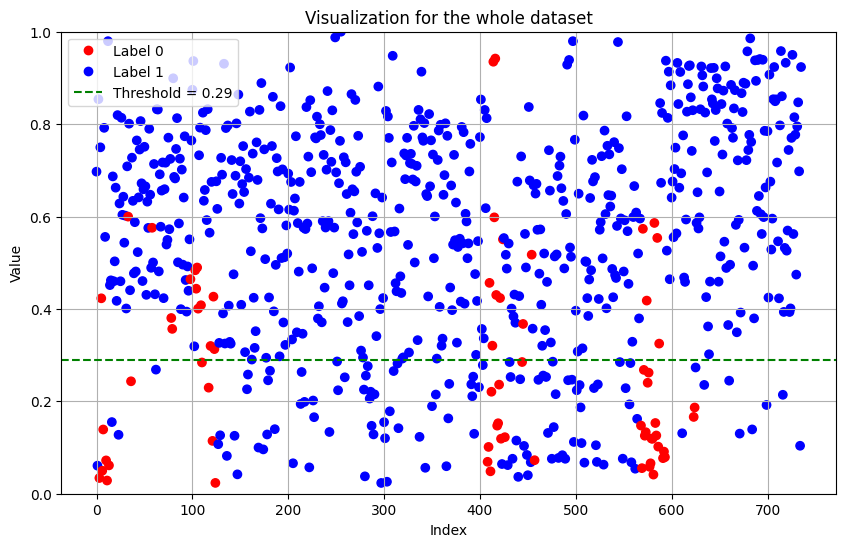

In [ ]:
#visualize
data = [x[2] for x in tweet_annotation_sentiment_distance]
labels = [x[1] for x in tweet_annotation_sentiment_distance] # 0 for red, 1 for blue
threshold = best_threshold

colors = ['red' if label == 0 else 'blue' for label in labels]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(data)), data, color=colors, label='Data Points')
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Visualization for the whole dataset')
plt.ylim(0,1)
plt.legend(handles=[
    plt.Line2D([0], [0], color='red', marker='o', linestyle='None', label='Label 0'),
    plt.Line2D([0], [0], color='blue', marker='o', linestyle='None', label='Label 1'),
    plt.Line2D([0], [0], color='green', linestyle='--', label=f'Threshold = {threshold}')
])
plt.grid()
plt.show()

# Train/Test

In [ ]:
#Get the sentiment distances for each tweet and the maximum sentiment distance in advance
# tweet_annotation_sentiment_distance = get_sentiment_distance(df['modified_tweet'], df['sarcastic'], df['exp'], method="contextual")

## **TRAIN**: Defining the **Best Threshold** with KFold (k=5) Training and Testing

100%|██████████| 101/101 [00:00<00:00, 189.07it/s]


Best threshold: 0.33
F-0.3 score: 0.942095439052102
              precision    recall  f1-score   support

           0       0.23      0.60      0.33        15
           1       0.94      0.77      0.85       133

    accuracy                           0.75       148
   macro avg       0.58      0.68      0.59       148
weighted avg       0.87      0.75      0.79       148



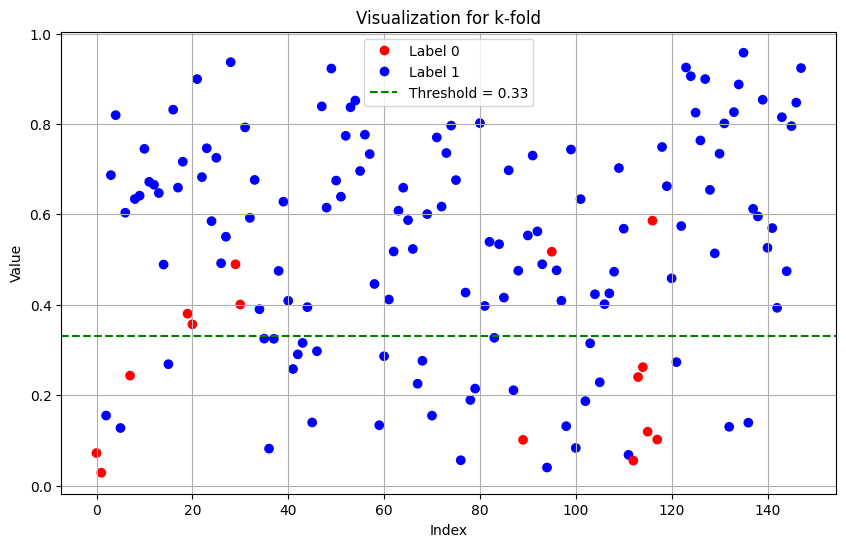

------


100%|██████████| 101/101 [00:00<00:00, 169.59it/s]


Best threshold: 0.45
F-0.3 score: 0.9403562768140272
              precision    recall  f1-score   support

           0       0.20      0.79      0.31        14
           1       0.97      0.66      0.79       133

    accuracy                           0.67       147
   macro avg       0.58      0.72      0.55       147
weighted avg       0.89      0.67      0.74       147



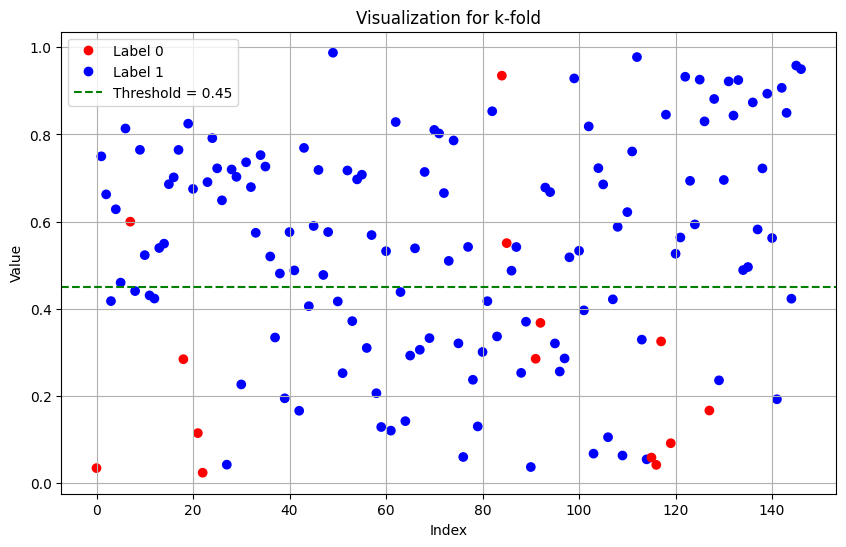

------


100%|██████████| 101/101 [00:00<00:00, 176.08it/s]


Best threshold: 0.37
F-0.3 score: 0.9418149314718652
              precision    recall  f1-score   support

           0       0.22      0.50      0.30        14
           1       0.94      0.81      0.87       133

    accuracy                           0.78       147
   macro avg       0.58      0.66      0.59       147
weighted avg       0.87      0.78      0.82       147



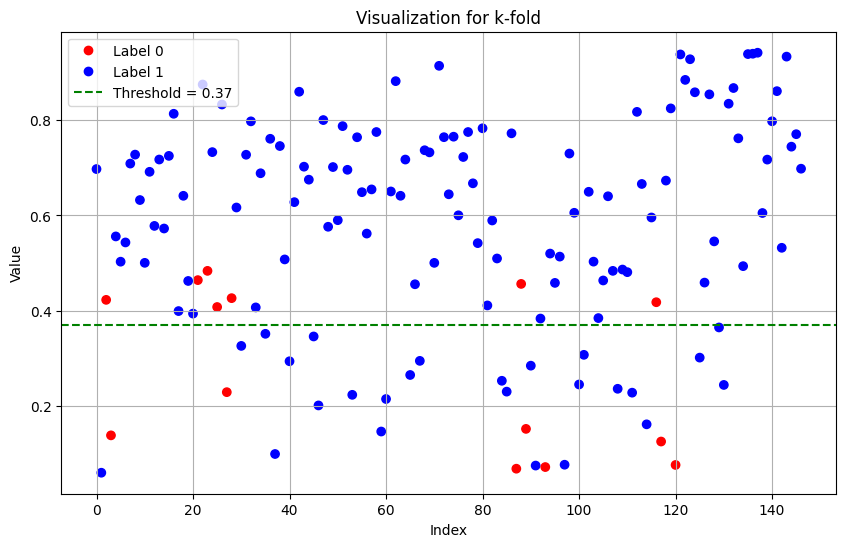

------


100%|██████████| 101/101 [00:00<00:00, 288.36it/s]


Best threshold: 0.43
F-0.3 score: 0.9412823550856727
              precision    recall  f1-score   support

           0       0.18      0.71      0.29        14
           1       0.96      0.66      0.78       133

    accuracy                           0.67       147
   macro avg       0.57      0.69      0.54       147
weighted avg       0.88      0.67      0.74       147



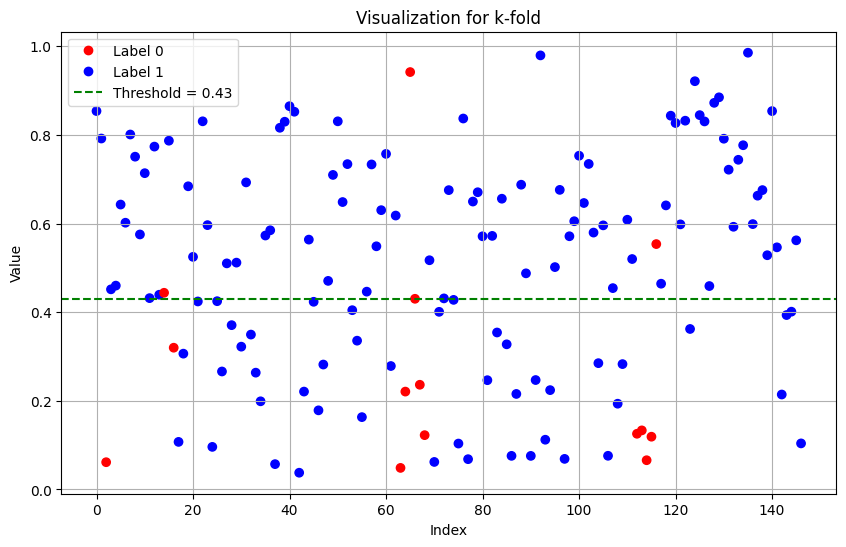

------


100%|██████████| 101/101 [00:00<00:00, 273.95it/s]


Best threshold: 0.29
F-0.3 score: 0.9387723144378328
              precision    recall  f1-score   support

           0       0.30      0.57      0.39        14
           1       0.95      0.86      0.90       133

    accuracy                           0.83       147
   macro avg       0.62      0.71      0.65       147
weighted avg       0.89      0.83      0.85       147



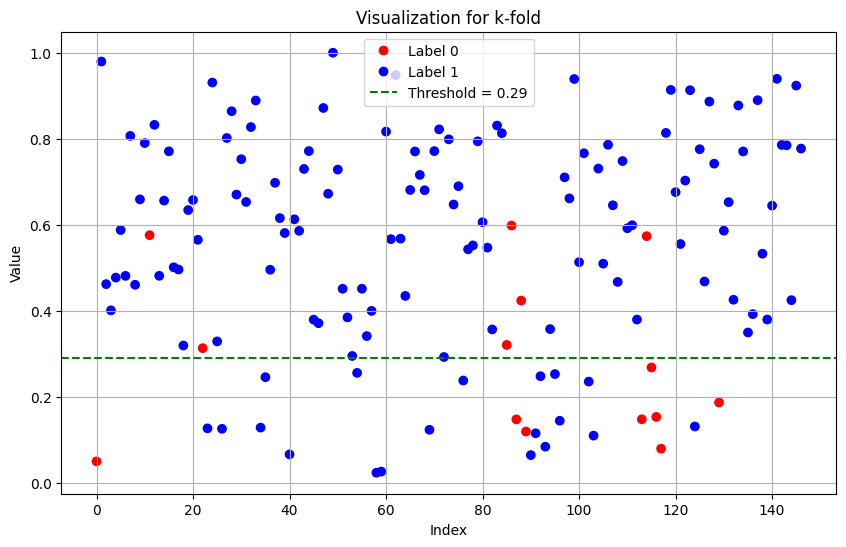

------


In [ ]:
gap = 0.01
threshold_list = list(np.arange(0, 1 + gap, gap))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tweets = [x[0] for x in tweet_annotation_sentiment_distance]
targets = [x[1] for x in tweet_annotation_sentiment_distance]
sentiment_distances = [x[2] for x in tweet_annotation_sentiment_distance]

thresholds = []

for train_index, test_index in skf.split(tweets, targets):

  train = [val for i, val in enumerate(tweet_annotation_sentiment_distance) if i in train_index]
  test = [val for i, val in enumerate(tweet_annotation_sentiment_distance) if i in test_index]

  threshold_accuracy_dict = define_threshold(train, threshold_list, metric="f-score")

  best_threshold = max(threshold_accuracy_dict, key=threshold_accuracy_dict.get)
  thresholds.append(best_threshold)
  print("Best threshold:", best_threshold)
  print("F-0.3 score:", threshold_accuracy_dict[best_threshold])

  print(classification_report( [x[1] for x in test], [int(is_sarc(x[2], best_threshold)) for x in test], zero_division=0))

  data = [x[2] for x in test]
  labels = [x[1] for x in test] # 0 for red, 1 for blue
  threshold = best_threshold

  colors = ['red' if label == 0 else 'blue' for label in labels]

  plt.figure(figsize=(10, 6))
  plt.scatter(range(len(data)), data, color=colors, label='Data Points')
  plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold}')
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('Visualization for k-fold')
  plt.legend(handles=[
      plt.Line2D([0], [0], color='red', marker='o', linestyle='None', label='Label 0'),
      plt.Line2D([0], [0], color='blue', marker='o', linestyle='None', label='Label 1'),
      plt.Line2D([0], [0], color='green', linestyle='--', label=f'Threshold = {threshold}')
  ])
  plt.grid()
  plt.show()

  print('------')

## **TEST**: Applying the **Best Threshold** to a Test Sample (20% of exp_final, stratified)

In [ ]:
_, df_test = train_test_split(df, test_size=0.2, stratify=df['sarcastic'], random_state=27)
df_test = df_test.reset_index()

In [ ]:
final_threshold = np.mean(thresholds)
print("Final threshold:", final_threshold)

Final threshold: 0.374


In [ ]:
#test
df_test['prediction'] = None
df_test['correct'] = None
for i in range(df_test.shape[0]):
 df_test.at[i, 'prediction'] = int(is_sarc(df_test['sentiment_distance'][i], final_threshold))  ###!!!!!!!!!!!!!!! tmp_threshold?
 df_test.at[i, 'correct'] = int(df_test.at[i, 'prediction'] ==df_test.at[i, 'sarcastic'])

In [ ]:
print(classification_report(df_test['sarcastic'].to_list(), [int(is_sarc(x, final_threshold)) for x in df_test['sentiment_distance'].to_list()], zero_division=0))

              precision    recall  f1-score   support

           0       0.24      0.71      0.36        14
           1       0.96      0.77      0.85       134

    accuracy                           0.76       148
   macro avg       0.60      0.74      0.61       148
weighted avg       0.89      0.76      0.81       148



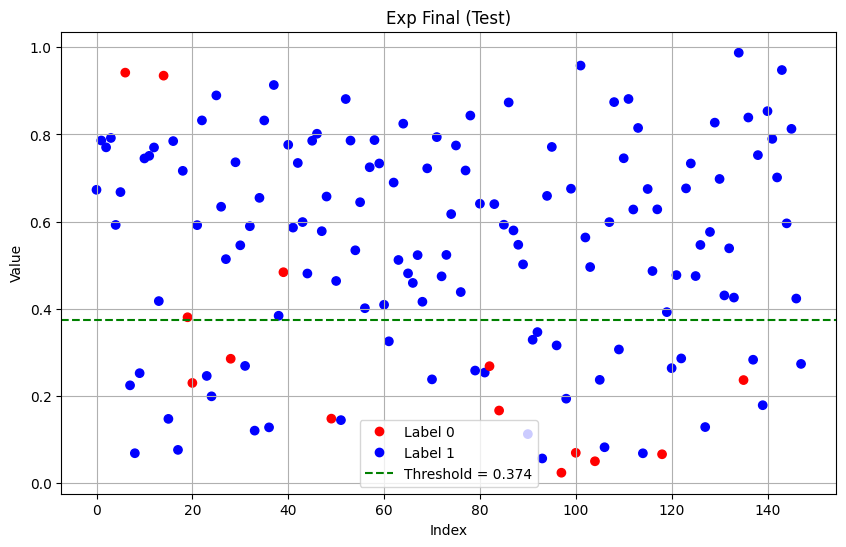

In [ ]:
#visualize

data = df_test['sentiment_distance']
labels = df_test['sarcastic']  # 0 for red, 1 for blue
threshold = np.mean(thresholds)

colors = ['red' if label == 0 else 'blue' for label in labels]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(data)), data, color=colors, label='Data Points')
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Exp Final (Test)')
plt.legend(handles=[
    plt.Line2D([0], [0], color='red', marker='o', linestyle='None', label='Label 0'),
    plt.Line2D([0], [0], color='blue', marker='o', linestyle='None', label='Label 1'),
    plt.Line2D([0], [0], color='green', linestyle='--', label=f'Threshold = {threshold}')
])
plt.grid()
plt.show()

# Other

In [ ]:
def define_threshold(tweets, gold_annotations, threshold_list, method, metric):
  """
  Creates a list of tuples containing 1) the tweet body, 2) the sarc/non-sarc gold annotation, 3) the sentiment distance between V and NP.
  Then, iterates over a list of thresholds and for each threshold calculates the accuracy between the gold annotations and the predicted values.
  Returns a dictionary of thresholds and accuracies for those thresholds.
  """

  threshold_accuracy_dict = {}
  for threshold in threshold_list:
    y_true = [item[1] for item in tweet_annotation_sentiment_distance]
    y_pred = [int(is_sarc(item[2], threshold)) for item in tweet_annotation_sentiment_distance]

    if metric == "f-score":
      score = fbeta_score(y_true, y_pred, beta=0.5)

    if metric == "precision":
      score = precision_score(y_true, y_pred, zero_division=0)

    if metric == "youden_j":
      tpr, tpr, thresholds = roc_curve(y_true, y_pred)
      print(tpr, fpr)
      print("/////////////////////////")
      score = np.argmax(tpr - fpr)

    threshold_accuracy_dict[threshold] = score

  return threshold_accuracy_dict, tweet_annotation_sentiment_distance

In [ ]:
# Exploring different beta parameters for F-score
for beta in np.arange(0.1, 0.8, 0.01) :
  gap = 0.1
  threshold_list = list(np.arange(0, max_sentiment, gap))

  threshold_accuracy_dict = define_threshold(tweet_annotation_sentiment_distance, threshold_list, metric="f-score", beta=beta)

  best_threshold = max(threshold_accuracy_dict, key=threshold_accuracy_dict.get)
  df['prediction'] = None
  df['correct'] = None
  df['sentiment distance'] = None
  for i in range(df.shape[0]):
    df.at[i, 'sentiment distance'] = tweet_annotation_sentiment_distance[i][2]
    df.at[i, 'prediction'] = int(is_sarc(df['sentiment distance'][i], best_threshold))
    df.at[i, 'correct'] = int(df.at[i, 'prediction'] ==df.at[i, 'sarcastic'])
  print('beta = ', beta)
  print(classification_report(df['sarcastic'].to_list(), df['prediction'].to_list(), zero_division=0))
  print("-----------------------------------------")


100%|██████████| 75/75 [00:00<00:00, 344.19it/s]


beta =  0.1
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 364.96it/s]


beta =  0.11
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 339.29it/s]


beta =  0.12
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 355.68it/s]


beta =  0.13
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 372.21it/s]


beta =  0.13999999999999999
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 354.92it/s]


beta =  0.14999999999999997
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 300.90it/s]


beta =  0.15999999999999998
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 371.91it/s]


beta =  0.16999999999999998
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 355.03it/s]


beta =  0.17999999999999997
              precision    recall  f1-score   support

           0       0.16      0.97      0.28        71
           1       0.99      0.47      0.64       665

    accuracy                           0.52       736
   macro avg       0.58      0.72      0.46       736
weighted avg       0.91      0.52      0.61       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 338.73it/s]


beta =  0.18999999999999995
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 383.85it/s]


beta =  0.19999999999999996
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 367.68it/s]


beta =  0.20999999999999996
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 312.15it/s]


beta =  0.21999999999999995
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 334.82it/s]


beta =  0.22999999999999995
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 387.13it/s]


beta =  0.23999999999999994
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 365.50it/s]


beta =  0.24999999999999992
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 370.14it/s]


beta =  0.2599999999999999
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 375.99it/s]


beta =  0.2699999999999999
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 340.43it/s]


beta =  0.2799999999999999
              precision    recall  f1-score   support

           0       0.21      0.83      0.33        71
           1       0.97      0.66      0.79       665

    accuracy                           0.68       736
   macro avg       0.59      0.75      0.56       736
weighted avg       0.90      0.68      0.74       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 329.88it/s]


beta =  0.2899999999999999
              precision    recall  f1-score   support

           0       0.26      0.63      0.37        71
           1       0.95      0.81      0.87       665

    accuracy                           0.79       736
   macro avg       0.61      0.72      0.62       736
weighted avg       0.89      0.79      0.82       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 381.30it/s]


beta =  0.29999999999999993
              precision    recall  f1-score   support

           0       0.26      0.63      0.37        71
           1       0.95      0.81      0.87       665

    accuracy                           0.79       736
   macro avg       0.61      0.72      0.62       736
weighted avg       0.89      0.79      0.82       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 334.53it/s]


beta =  0.30999999999999994
              precision    recall  f1-score   support

           0       0.26      0.63      0.37        71
           1       0.95      0.81      0.87       665

    accuracy                           0.79       736
   macro avg       0.61      0.72      0.62       736
weighted avg       0.89      0.79      0.82       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 315.43it/s]


beta =  0.3199999999999999
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 246.80it/s]


beta =  0.32999999999999985
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 221.59it/s]


beta =  0.33999999999999986
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 255.66it/s]


beta =  0.34999999999999987
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 260.99it/s]


beta =  0.3599999999999999
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 205.04it/s]


beta =  0.3699999999999999
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 188.59it/s]


beta =  0.3799999999999999
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 218.08it/s]


beta =  0.3899999999999999
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 273.84it/s]


beta =  0.3999999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 351.31it/s]


beta =  0.4099999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 350.79it/s]


beta =  0.4199999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 374.34it/s]


beta =  0.4299999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 360.24it/s]


beta =  0.43999999999999984
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 370.48it/s]


beta =  0.44999999999999984
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 394.52it/s]


beta =  0.45999999999999985
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 329.07it/s]


beta =  0.46999999999999986
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 336.49it/s]


beta =  0.47999999999999976
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 349.96it/s]


beta =  0.48999999999999977
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 302.39it/s]


beta =  0.4999999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 373.32it/s]


beta =  0.5099999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 348.79it/s]


beta =  0.5199999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 300.44it/s]


beta =  0.5299999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 357.93it/s]


beta =  0.5399999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 371.21it/s]


beta =  0.5499999999999998
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        71
           1       0.94      0.91      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.69      0.66       736
weighted avg       0.88      0.87      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 311.93it/s]


beta =  0.5599999999999997
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 366.84it/s]


beta =  0.5699999999999997
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 369.47it/s]


beta =  0.5799999999999997
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 360.04it/s]


beta =  0.5899999999999997
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 341.45it/s]


beta =  0.5999999999999998
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 338.89it/s]


beta =  0.6099999999999998
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 315.88it/s]


beta =  0.6199999999999998
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 345.39it/s]


beta =  0.6299999999999997
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        71
           1       0.94      0.92      0.93       665

    accuracy                           0.87       736
   macro avg       0.65      0.68      0.66       736
weighted avg       0.88      0.87      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 376.11it/s]


beta =  0.6399999999999997
              precision    recall  f1-score   support

           0       0.37      0.31      0.34        71
           1       0.93      0.94      0.94       665

    accuracy                           0.88       736
   macro avg       0.65      0.63      0.64       736
weighted avg       0.87      0.88      0.88       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 381.65it/s]


beta =  0.6499999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 316.85it/s]


beta =  0.6599999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 379.45it/s]


beta =  0.6699999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 333.73it/s]


beta =  0.6799999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 313.87it/s]


beta =  0.6899999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 331.61it/s]


beta =  0.6999999999999996
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 384.87it/s]


beta =  0.7099999999999996
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 208.47it/s]


beta =  0.7199999999999996
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 230.84it/s]


beta =  0.7299999999999996
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 230.79it/s]


beta =  0.7399999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 210.08it/s]


beta =  0.7499999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 197.69it/s]


beta =  0.7599999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 265.51it/s]


beta =  0.7699999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 322.11it/s]


beta =  0.7799999999999997
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


100%|██████████| 75/75 [00:00<00:00, 326.30it/s]


beta =  0.7899999999999996
              precision    recall  f1-score   support

           0       0.50      0.08      0.14        71
           1       0.91      0.99      0.95       665

    accuracy                           0.90       736
   macro avg       0.71      0.54      0.55       736
weighted avg       0.87      0.90      0.87       736

-----------------------------------------


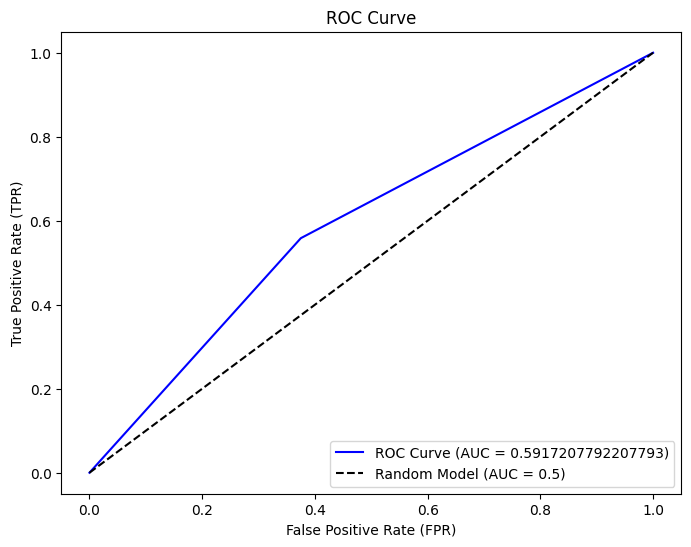

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(df_test['sarcastic'], df_test['prediction'])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(df_test['sarcastic'], df_test['prediction'])})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Model (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#train
tweet_annotation_sentiment_distance, max_sentiment = get_sentiment_distance(df_train['modified_tweet'], df_train['sarcastic'], df_train['exp'], method="contextual")


gap = 0.01
threshold_list = list(np.arange(0, max_sentiment, gap))

threshold_accuracy_dict = define_threshold(tweet_annotation_sentiment_distance, threshold_list, metric="f-score")

best_threshold = max(threshold_accuracy_dict, key=threshold_accuracy_dict.get)
print("Best threshold:", best_threshold)
print("F-0.3 score:", threshold_accuracy_dict[best_threshold])


100%|██████████| 731/731 [00:01<00:00, 375.65it/s]

Best threshold: 1.1500000000000001
F-0.3 score: 0.9354590856703804
